In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 973826.69it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 57823.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1266013.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3764926.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [3]:
for images, labels in train_loader:
    print(images[0])
    break

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
d_noise = 100
d_hidden_1 = 256
d_hidden_2 = 256
image_dim = 28*28
batch_size = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(d_noise, 256, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), d_noise, 1, 1)  # 입력 잡음 벡터를 (batch_size, d_noise, 1, 1) 형태로 변환
        x = self.generator(x)
        return x

    def forward(self, x):
        x = self.generator(x)
        return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(28*28, d_hidden_1),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden_1, d_hidden_2),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden_2, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        x = self.discriminator(x)
        return x

In [12]:
disc = Discriminator().to(device)
gen = Generator().to(device)

fixed_noise = torch.randn(batch_size, d_noise).view(batch_size, d_noise, 1, 1).to(device)

lr = 3e-4
num_epochs = 50

opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real= SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

In [13]:
fake_list = []
real_list = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, d_noise).view(batch_size, d_noise, 1, 1).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.view(-1, 784)).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake.view(-1, 784)).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)

                fake_list.append(fake)
                real_list.append(data)
                step += 1

Epoch [0/50] Loss D: 0.7218, loss G: 0.7052
Epoch [1/50] Loss D: 0.6322, loss G: 0.9314
Epoch [2/50] Loss D: 0.6251, loss G: 0.9769
Epoch [3/50] Loss D: 0.5735, loss G: 1.0137
Epoch [4/50] Loss D: 0.6645, loss G: 0.7921
Epoch [5/50] Loss D: 0.6416, loss G: 0.7984
Epoch [6/50] Loss D: 0.6553, loss G: 0.7159
Epoch [7/50] Loss D: 0.6116, loss G: 0.9643
Epoch [8/50] Loss D: 0.6208, loss G: 0.8218
Epoch [9/50] Loss D: 0.6630, loss G: 0.7133
Epoch [10/50] Loss D: 0.6810, loss G: 0.7121
Epoch [11/50] Loss D: 0.6692, loss G: 0.7387
Epoch [12/50] Loss D: 0.6394, loss G: 0.7014
Epoch [13/50] Loss D: 0.7154, loss G: 0.6390
Epoch [14/50] Loss D: 0.6842, loss G: 0.6811
Epoch [15/50] Loss D: 0.5978, loss G: 0.9690
Epoch [16/50] Loss D: 0.7135, loss G: 0.7223
Epoch [17/50] Loss D: 0.7037, loss G: 0.7627
Epoch [18/50] Loss D: 0.6375, loss G: 0.9172
Epoch [19/50] Loss D: 0.6840, loss G: 0.6674
Epoch [20/50] Loss D: 0.6545, loss G: 0.7367
Epoch [21/50] Loss D: 0.7034, loss G: 0.6993
Epoch [22/50] Loss D

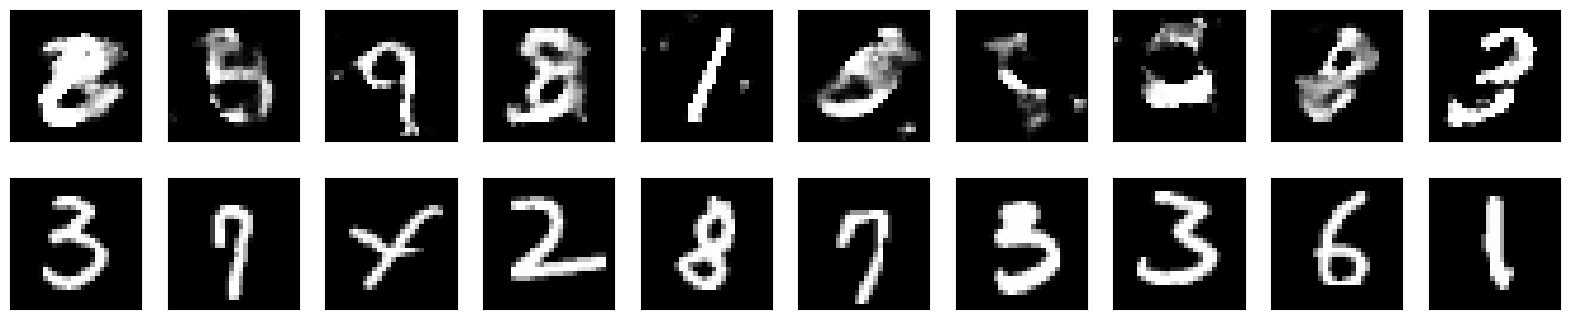

In [14]:
# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([fake_list[-1], real_list[-1]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.cpu().numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
!pip install tensorboard

In [ ]:
!tensorboard --logdir=runs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs


In [ ]:
# 모델 초기화
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.view(-1, 28 * 28).to(device)

        # 순전파
        output = model(data)
        loss = criterion(output, data)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 테스트 데이터셋에서 몇 가지 이미지를 복원하여 시각화
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28 * 28).to(device)
        output = model(data)
        output = output.view(-1, 1, 28, 28).cpu()
        break

# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([data.view(-1, 1, 28, 28).cpu(), output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()